# Model Comparison

## Data
Heart Failure Prediction Dataset

1. Age: Age of the patient [years]
2. Sex: Sex of the patient [M: Male, F: Female]
3. ChestPainType: [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: Resting blood pressure [mm Hg]
5. Cholesterol: Serum cholesterol [mm/dl]
6. FastingBS: Fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: Maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: Exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: ST [Numeric value measured in depression] (
11. ST_Slope: The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: Output class [1: heart disease, 0: Normal]

**Source** : https://www.kaggle.com/fedesoriano/heart-failure-prediction.



## Problem
- Type of problem - **Classification**
- Given the input data, classify the individual as with heart disease (category 1) or normal (category 0)


## Objective
- Perform the exploratory data analysis to make the data fit for purpose
- Test multiple models to establish the best performing model (linear and non linear models) under default conditions
- Pick the best performing model and tune the parameters to increase the model accuracy


## Exploratory Data Analysis

In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import all common libraries for models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Import libraries related to the models
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Import libraries for optimizing the parameters
import optuna

In [442]:
# Load the input csv file
df = pd.read_csv("data/heart-failure-prediction.csv")
df.reset_index(drop=True) # This statement resets the index and removes the rows with NaN values. This can be handled in several other ways, which are no included in scope for this notebook
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [331]:
# Check for null values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no null values in the dataset for any of the columns.

In [441]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The numerical columns do not seem to have extreme values (min and max rows) that could be immediately identied as outliers. Further analysis will be done on outliers later

### Analyse the numerical features

Create a histogram for the numerical values

In [333]:
# get the numerical features from the dataset
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

print(f'Numerical Columns:  {df[numerical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

<Figure size 1152x720 with 0 Axes>

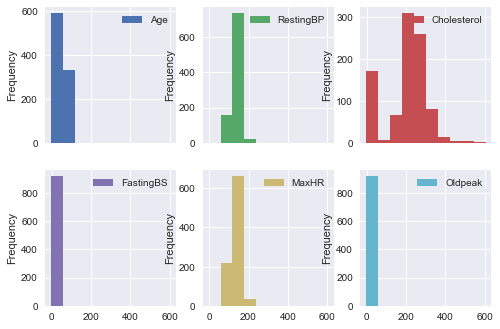

In [443]:
# Plot all the numerical columns as histograms
plt.style.use('seaborn')
plt.figure(figsize=(16,10))
df[numerical].plot.hist(subplots=True, legend=True, layout=(2, 3))

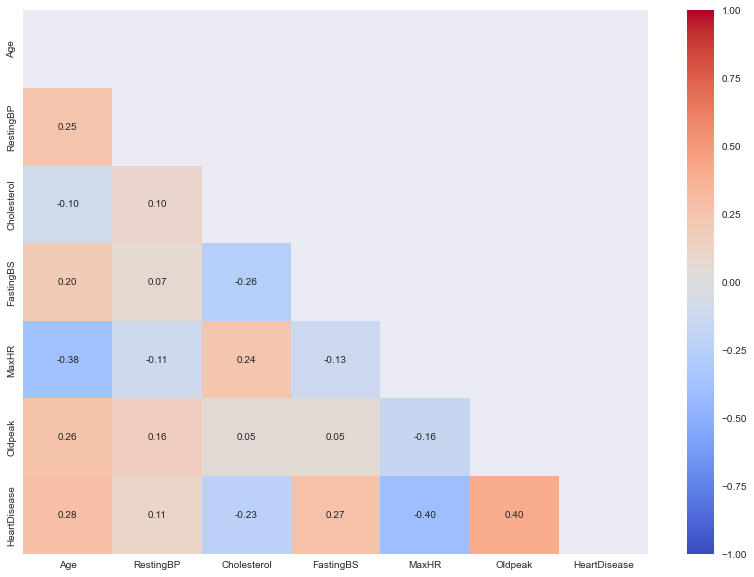

In [335]:
numerical_with_output = df.select_dtypes('number').columns

matrix = np.triu(df[numerical_with_output].corr())
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df[numerical_with_output].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);


Based on the heatmap, we can observe the following
1. There is no strong correlation between numerical features and the output
2. OldPeak (depression related number) has a high correlation with heart disease
3. Cholestrol (surprisingly) has a negative correlation with heart disease
4. Maximum Heart Rate also has a negative correlation with heart disease

### Analysis of Categorical features

In [336]:
# Get the categorical features from the dataset
categorical = df.select_dtypes('object').columns

print(f'Categorical Columns:  {df[categorical].columns}')

Categorical Columns:  Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [337]:
df[categorical].head()


,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


#### Gender and Heart Disease

A female has a probability of 25.91% to have a heart disease
A male has a probability of 63.17% to have a heart disease


<AxesSubplot:xlabel='Sex', ylabel='count'>

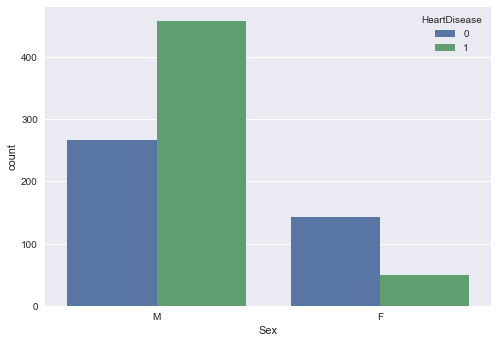

In [338]:
print(f'A female has a probability of {round(df[df["Sex"]=="F"]["HeartDisease"].mean()*100, 2)}% to have a heart disease')
print(f'A male has a probability of {round(df[df["Sex"]=="M"]["HeartDisease"].mean()*100, 2)}% to have a heart disease')

# Create a count plot showing the number of males and females
sns.countplot(data=df, x="Sex", hue="HeartDisease")

Males are 2.44 times more likely to have heart disease than women

#### Chest Pain Type and Heart Disease

In [444]:
# Show the heart disease probability by chest pain type
df.groupby("ChestPainType")["HeartDisease"].mean().sort_values(ascending=False)

ChestPainType
ASY    0.790323
TA     0.434783
NAP    0.354680
ATA    0.138728
Name: HeartDisease, dtype: float64

<AxesSubplot:xlabel='ChestPainType', ylabel='count'>

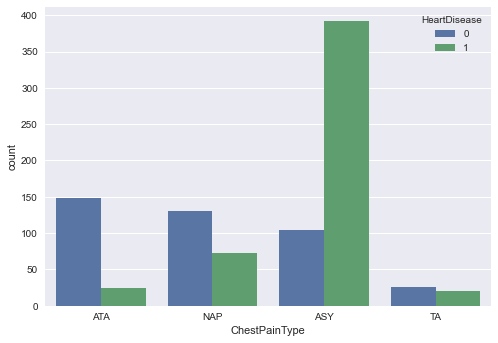

In [445]:
sns.countplot(data=df, x="ChestPainType", hue="HeartDisease")

Observations:
1. Nearly 4 out of 5 times when a person has ASY (Asymptomatic chest pain), it points to heart disease

#### Exercise Type and Heart Disease

In [446]:
# Show the heart disease probability by chest pain type
df.groupby("ExerciseAngina")["HeartDisease"].mean().sort_values(ascending=False)

ExerciseAngina
Y    0.851752
N    0.351005
Name: HeartDisease, dtype: float64

<AxesSubplot:xlabel='ExerciseAngina', ylabel='count'>

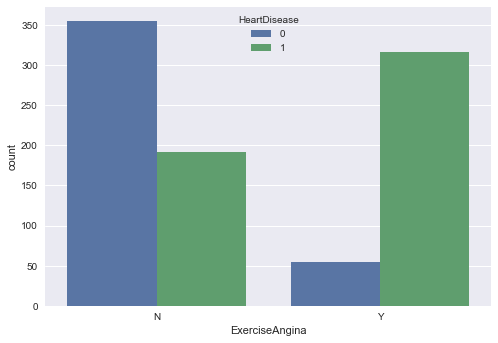

In [342]:
sns.countplot(data=df, x="ExerciseAngina", hue="HeartDisease")

#### Resting ECG and Heart Disease

In [343]:
df.groupby("RestingECG")["HeartDisease"].mean().sort_values(ascending=False)

RestingECG
ST        0.657303
LVH       0.563830
Normal    0.516304
Name: HeartDisease, dtype: float64

<AxesSubplot:xlabel='RestingECG', ylabel='count'>

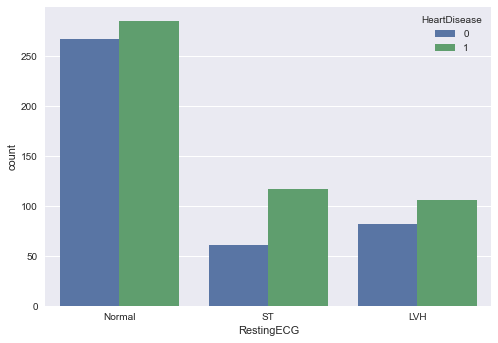

In [344]:
sns.countplot(data=df, x="RestingECG", hue="HeartDisease")

Observations:
1. The data seems to be fairly balanced for all 3 categories.
2. If an individual exhibits ST-T wave abnormility, the chances of heart disease are higher (65.1%) than the other 2 categories (56.3% and 51.6%).

#### ST_Slope and Heart Disease

In [345]:
df.groupby("ST_Slope")["HeartDisease"].mean().sort_values(ascending=False)

ST_Slope
Flat    0.828261
Down    0.777778
Up      0.197468
Name: HeartDisease, dtype: float64

<AxesSubplot:xlabel='ST_Slope', ylabel='count'>

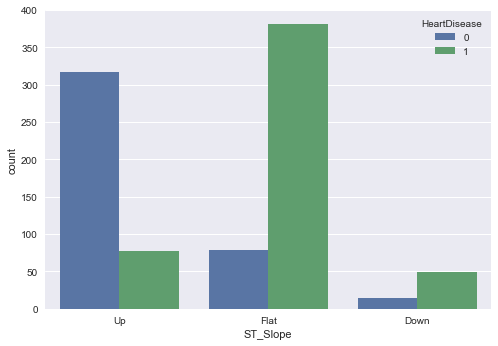

In [346]:
sns.countplot(data=df, x="ST_Slope", hue="HeartDisease")

Observations:
- If the slopw of the peak exercise ST segment is flat, it indicates a near 82.8% probability of a heart disease

### Remove outliers

In [347]:
# Check for outliers
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df[numerical]))
print(f'Original shape: {df.shape}')

# Filter out the values with z score higher than 3
threshold = 3
df[numerical]= df[numerical][(z < threshold).all(axis=1)]
print(f'Shape after outlier removal: {df.shape}')

Original shape: (918, 12)
Shape after outlier removal: (918, 12)


No outliers detected in the numerical columns

## Check for imbalance in output

In [447]:

# Check for imbalance
y = df.HeartDisease
print(f'Percentage of patient had a HeartDisease:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} patient)')


Percentage of patient had a HeartDisease:  55.34 %  --> (508 patient)
Percentage of patient did not have a HeartDisease: 44.66  %  --> (410 patient)


<AxesSubplot:ylabel='Frequency'>

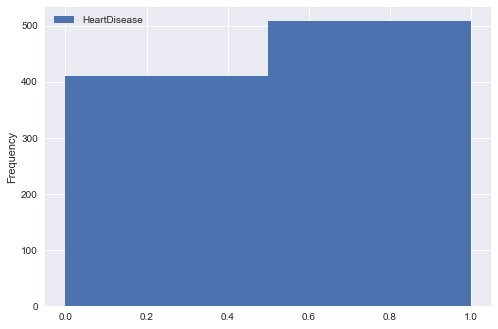

In [349]:
df.HeartDisease.plot.hist(legend=True, bins=2)

Observations:
- This is a fairly balanced output. 55.34% had heart diseases and 44.66% did not.

## Model Selection

- Multiple models will be used to train on the dataset and make predictions. Finally we will compare the models to see which was the best performing
- Models under test
    - Dummy classifier as a base model
    - Logistic Regression (with and without scalar)
    - Linear Discriminant (with and without scalar)
    - K-Nearest Neighbors (KNN) (with and without scalar)
    - Support Vector Machine (SVM) (with and without scalar)
    - Ensemble methods :
        - Adaboost
        - Random Forest
        - Gradient Boosting
        - Extra Trees
    - Other famous models
        - XGBoost
        - LightGBM
        - CatBoost
- Hyperparamater tuning for CatBoost model


### Baseline Model

In [459]:
model_accuracy = []
model_names = []

X = df.drop("HeartDisease", axis=1)
y = df.HeartDisease

In [449]:
# Divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform onehotencoding for categorical features and scaling for numerical features
def encode_and_scale_df(scale_flag):
    ohe = OneHotEncoder()
    if scale_flag == True:
        s = StandardScaler()
        ct = make_column_transformer((ohe, categorical), (s, numerical)) # By specifying remainder='passthrough', all remaining columns that were not specified in transformers will be automatically passed through.
    else:
        ct = make_column_transformer((ohe, categorical), remainder='passthrough') # By specifying remainder='passthrough', all remaining columns that were not specified in transformers will be automatically passed through.
    return ct

In [450]:
# Create a horizontal bar plot showing the features important to a model in decreasing order
def feature_importance(model):
    feature_importance = np.array(model.get_feature_importance())
    features = np.array(X_train.columns)
    fi={'features':features,'feature_importance':feature_importance}

    # Convert to dataframe and sort by importance descending
    df_fi = pd.DataFrame(fi)
    df_fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    sns.barplot(data=df_fi, x='feature_importance', y='features')
    plt.title("CatBoost Feature Importance")
    plt.show()

In [451]:
# Function to train the model, make prediction and calculate the accuracy
def create_model(model_name, scale_flag, **tuned_params):

    if model_name == "Dummy Classifier":
        model = DummyClassifier(strategy='constant', constant=1)
    elif model_name == "Logistic Regression" or  model_name == "Logistic Regression - scaled":
        model = LogisticRegression(solver='liblinear')
    elif model_name == "Linear Discriminant Analysis" or model_name == "Linear Discriminant Analysis - scaled":
        model = LinearDiscriminantAnalysis()
    elif model_name == "SVM" or model_name == "SVM - scaled":
        model = SVC(gamma='scale')
    elif model_name == "K-Neighbor Classifier" or model_name == "K-Neighbor Classifier - scaled":
        model = KNeighborsClassifier()
    elif model_name == "AdaBoost":
        model = AdaBoostClassifier(random_state=0)
    elif model_name == "Gradient Boosting":
        model = GradientBoostingClassifier(random_state=0)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(random_state=0)
    elif model_name == "Extra Trees":
        model = ExtraTreesClassifier(random_state=0)
    elif model_name == "XGBoost":
        model = XGBClassifier(random_state=0)
    elif model_name == "LightGBM":
        model = LGBMClassifier(random_state=0)
    elif model_name == "CatBoost":
        model = CatBoostClassifier(verbose=False, random_state=0)

        # Get the indices of the columns that are categorical
        categorical_indices = np.where(X.dtypes != float)[0]
    elif model_name == "CatBoost - tuned":
        model = CatBoostClassifier(verbose=False,random_state=0,
                    objective = tuned_params["tuned_params"]["objective"],
                    colsample_bylevel= tuned_params["tuned_params"]["colsample_bylevel"],
                    depth= tuned_params["tuned_params"]["depth"],
                    boosting_type= tuned_params["tuned_params"]["boosting_type"],
                    bootstrap_type= tuned_params["tuned_params"]["bootstrap_type"])

        # Get the indices of the columns that are categorical
        categorical_indices = np.where(X.dtypes != float)[0]

    # Create the model
    if model_name == "CatBoost":
        model.fit(X_train, y_train, cat_features=categorical_indices, eval_set=(X_test, y_test))

        # Prediction the output on test set
        y_pred = model.predict(X_test)
    elif model_name == "CatBoost - tuned":
        model.fit(X_train, y_train, cat_features=categorical_indices, eval_set=(X_test, y_test))

        # Prediction the output on test set
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))

        # Feature importance
        feature_importance(model)
    else:
        ct = encode_and_scale_df(scale_flag)
        pipe = make_pipeline(ct, model)
        pipe.fit(X_train, y_train)

        # Predict the output on the test set
        y_pred = pipe.predict(X_test)

    # Calculate accuracy
    acc_score = round(accuracy_score(y_test, y_pred),4)

    # Print the model accuracy
    print(f'Model: {model} ; Accuracy Score: {acc_score*100}%')

    # Append the accuracy into the accuracy list
    model_accuracy.append(acc_score)
    model_names.append(model_name)




In [460]:
# Dummy Classifier

# Call the function for all models
create_model("Dummy Classifier", scale_flag=False)


Model: DummyClassifier(constant=1, strategy='constant') ; Accuracy Score: 59.419999999999995%


In [461]:
# Store the result in a dataframe
#result_df = pd.DataFrame({'Accuracy': model_accuracy}, index=model_names)
#result_df

### Part 2a: Logistic Regression, Linear Discriminant Analysis, SVM, K-Neighbor Classifier without Scaling

In [462]:
models_list = ["Logistic Regression", "Linear Discriminant Analysis", "SVM", "K-Neighbor Classifier"]
for model in models_list:
    create_model(model, scale_flag=False)

Model: LogisticRegression(solver='liblinear') ; Accuracy Score: 88.41%
Model: LinearDiscriminantAnalysis() ; Accuracy Score: 86.96000000000001%
Model: SVC() ; Accuracy Score: 72.46000000000001%
Model: KNeighborsClassifier() ; Accuracy Score: 71.74000000000001%


Notes about selecting solver for LogisticRegression model:
solver types : ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’. Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, consider the following aspects:
- For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones
- For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
- ‘liblinear’ is limited to one-versus-rest schemes.

### Part 2b: Logistic Regression, Linear Discriminant Analysis, SVM, K-Neighbor Classifier with Scaling

In [463]:
models_list = ["Logistic Regression - scaled", "Linear Discriminant Analysis - scaled", "SVM - scaled", "K-Neighbor Classifier - scaled"]
for models in models_list:
    create_model(models, scale_flag=True)

Model: LogisticRegression(solver='liblinear') ; Accuracy Score: 88.03999999999999%
Model: LinearDiscriminantAnalysis() ; Accuracy Score: 86.96000000000001%
Model: SVC() ; Accuracy Score: 88.41%
Model: KNeighborsClassifier() ; Accuracy Score: 88.41%


In [464]:
#result_df = pd.DataFrame({'Accuracy': model_accuracy}, index=model_names)
#result_df

Observations post scaling:
- SVM accuracy went from 72.46% to 88.41%
- K-Neighbors Classifier accuracy went up from 71.74% to 88.41%

### Part 3: Ensemble Models (AdaBoost & Gradient Boosting & Random Forest & Extra Trees)

In [465]:
models_list = ["AdaBoost", "Gradient Boosting", "Random Forest", "Extra Trees"]
for models in models_list:
    create_model(models, scale_flag=False)

Model: AdaBoostClassifier(random_state=0) ; Accuracy Score: 86.59%
Model: GradientBoostingClassifier(random_state=0) ; Accuracy Score: 87.68%
Model: RandomForestClassifier(random_state=0) ; Accuracy Score: 88.77000000000001%
Model: ExtraTreesClassifier(random_state=0) ; Accuracy Score: 88.03999999999999%


In [466]:
#result_df = pd.DataFrame({'Accuracy': model_accuracy}, index=model_names)
#result_df

### Part 4a: XGBoost & LightGBM

In [467]:
models_list = ["XGBoost", "LightGBM"]
for models in models_list:
    create_model(models, scale_flag=False)

/Users/mridul/opt/anaconda3/envs/python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) ; Accuracy Score: 82.97%
Model: LGBMClassifier(random_state=0) ; Accuracy Score: 87.32%


In [468]:
#result_df = pd.DataFrame({'Accuracy': model_accuracy}, index=model_names)
#result_df

### Part 4b: CatBoost - without optimization

In [469]:
create_model("CatBoost", scale_flag=False)

Model: <catboost.core.CatBoostClassifier object at 0x7fd05cdc8cd0> ; Accuracy Score: 88.03999999999999%


In [470]:
result_df = pd.DataFrame({'Accuracy': model_accuracy}, index=model_names)
result_df

,Accuracy
Dummy Classifier,0.5942
Logistic Regression,0.8841
Linear Discriminant Analysis,0.8696
SVM,0.7246
K-Neighbor Classifier,0.7174
Logistic Regression - scaled,0.8804
Linear Discriminant Analysis - scaled,0.8696
SVM - scaled,0.8841
K-Neighbor Classifier - scaled,0.8841
AdaBoost,0.8659


## Tuning Catboost model using OPTUNA

OPTUNA library was used to optimise the catboost algorithm. It has not been included in this notebook since there was incompatibility

In [471]:
# Hypertune the catboost model using optuna
def objective(trial):
    # Get indices that contain categorical features
    categorical_features_indices = np.where(X.dtypes != float)[0]

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type":trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type":trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    # Additional paramaters to be studied depending on the bootstrap type
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # Add params to the Catbood classifier
    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy


In [472]:
# Construct Study for hyperparameter optimization.
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials : {}".format(len(study.trials)))
print("Best trial : \n")
trial = study.best_trial
print("     Value : {}".format(trial.value))
print("Params : \n")

for key, value in trial.params.items():
    print("     {} : {}".format(key, value))


[I 2022-05-29 18:44:38,564] A new study created in memory with name: no-name-51c30858-4288-4876-8dfb-304717406ab2
[I 2022-05-29 18:44:38,900] Trial 0 finished with value: 0.8913043478260869 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.019249537000481952, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8913043478260869.
[I 2022-05-29 18:44:39,213] Trial 1 finished with value: 0.8514492753623188 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0332905212193338, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.857289289329981}. Best is trial 0 with value: 0.8913043478260869.
[I 2022-05-29 18:44:40,093] Trial 2 finished with value: 0.8623188405797102 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09013784134570069, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.8158506234194896}. Best is trial 0 with

Number of finished trials : 50
Best trial : 

     Value : 0.9057971014492754
Params : 

     objective : Logloss
     colsample_bylevel : 0.08253734633246051
     depth : 6
     boosting_type : Ordered
     bootstrap_type : Bayesian
     bagging_temperature : 0.10751383318362959


### Feature Importance using CatBoost

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       112
           1       0.93      0.90      0.91       164

    accuracy                           0.90       276
   macro avg       0.89      0.90      0.90       276
weighted avg       0.90      0.90      0.90       276



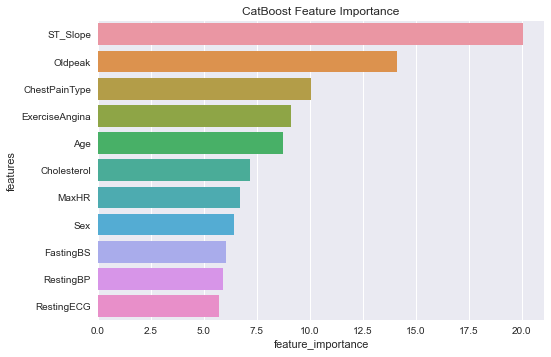

Model: <catboost.core.CatBoostClassifier object at 0x7fd078838c50> ; Accuracy Score: 89.86%


In [432]:
# Using the model with the best/tuned paramaters
create_model("CatBoost - tuned", scale_flag=False, tuned_params=trial.params)

In [433]:
result_df = pd.DataFrame({'Accuracy': model_accuracy}, index=model_names)
result_df

,Accuracy
Dummy Classifier,0.5942
Logistic Regression,0.8841
Linear Discriminant Analysis,0.8696
SVM,0.7246
K-Neighbor Classifier,0.7174
Logistic Regression - scaled,0.8804
Linear Discriminant Analysis - scaled,0.8696
SVM - scaled,0.8841
K-Neighbor Classifier - scaled,0.8841
AdaBoost,0.8659


Catboost feature importance

## Model Comparison

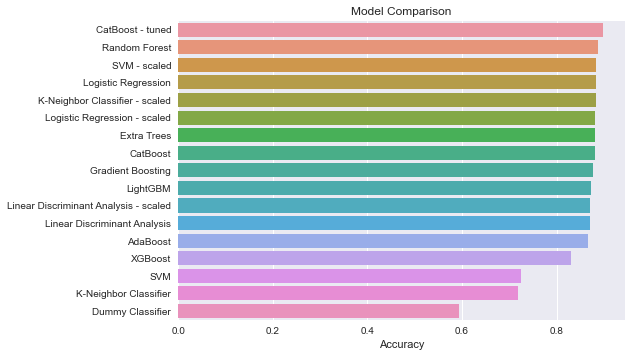

In [434]:
result_df.sort_values(by=['Accuracy'], ascending=False,inplace=True)
sns.barplot(data=result_df, x='Accuracy', y=result_df.index)
plt.title("Model Comparison")
plt.show()